# [Unit 04] 應用二：反應動力學模擬 (Reaction Kinetics Simulation)

**課程名稱**：化工資料科學與機器學習實務（CHE-AI-101）

**本單元目標**：
1.  **數值解 ODE**：使用 `scipy.integrate.odeint` 解常微分方程式，模擬連串反應 $A \to B \to C$。
2.  **製程優化**：找出中間產物 $B$ 的最大濃度與對應的最佳反應時間。
3.  **質量守恆**：驗證數值模擬結果的合理性。

In [ ]:
# ===== Shared environment (Part_0 compatible) =====
import os, sys
from pathlib import Path

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)

def find_repo_root(start=None):
    start = Path(start or os.getcwd()).resolve()
    for p in [start] + list(start.parents):
        if (p / 'Jupyter_Scripts').is_dir():
            return p
    if IN_COLAB:
        candidate = Path('/content/drive/MyDrive/ChemEng_AI_Course_Materials')
        if (candidate / 'Jupyter_Scripts').is_dir():
            return candidate
    return start

REPO_ROOT = find_repo_root()
OUTPUT_DIR = REPO_ROOT / 'outputs'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
os.chdir(OUTPUT_DIR)
print('REPO_ROOT:', REPO_ROOT)
print('Working dir:', os.getcwd())


In [11]:
# 匯入必要的套件
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.integrate import odeint

# 建立結果儲存資料夾
os.makedirs('Unit04_Results', exist_ok=True)

# 圖形設定
plt.rcParams["figure.figsize"] = (10, 6)
#plt.rcParams["font.sans-serif"] = ["Microsoft JhengHei", "Noto Sans CJK TC", "sans-serif"]
plt.rcParams["axes.unicode_minus"] = False

print("套件載入完成！")

套件載入完成！


---
## 1. 定義反應參數與初始條件

我們模擬一個連串一級反應 (Consecutive First-order Reaction)：
$$ A \xrightarrow{k_1} B \xrightarrow{k_2} C $$

- $k_1 = 0.3 \, s^{-1}$
- $k_2 = 0.1 \, s^{-1}$
- 初始濃度：$[A]_0 = 1.0 \, M, [B]_0 = 0, [C]_0 = 0$

In [12]:
# 反應速率常數 (Rate constants) [1/s]
k1 = 0.3  # A -> B
k2 = 0.1  # B -> C

# 初始濃度 [Ca0, Cb0, Cc0] (mol/L)
C0 = [1.0, 0.0, 0.0]

# 模擬時間：0 ~ 50 秒，取 100 個點
t = np.linspace(0.0, 50.0, 100)

print(f"參數設定：k1 = {k1}, k2 = {k2}")
print(f"初始濃度：[A]0 = {C0[0]}, [B]0 = {C0[1]}, [C]0 = {C0[2]}")

參數設定：k1 = 0.3, k2 = 0.1
初始濃度：[A]0 = 1.0, [B]0 = 0.0, [C]0 = 0.0


---
## 2. 定義微分方程模型 (ODE Model)

根據質量守恆定律，各成份的速率方程為：

$$ \frac{dC_A}{dt} = -k_1 C_A $$
$$ \frac{dC_B}{dt} = k_1 C_A - k_2 C_B $$
$$ \frac{dC_C}{dt} = k_2 C_B $$

我們需要定義一個函數 `reaction_model(C, t)` 來描述這些導數。

In [13]:
def reaction_model(C, t, k1, k2):
    """
    連串一級反應 A -> B -> C 的質量平衡 ODE 模型。
    輸入：
        C : [Ca, Cb, Cc] 在時間 t 的濃度
        t : 時間 (odeint 需要此參數)
        k1, k2 : 反應速率常數
    回傳：
        [dCa/dt, dCb/dt, dCc/dt]
    """
    Ca, Cb, Cc = C

    # 速率方程 (Rate laws)
    dCa_dt = -k1 * Ca
    dCb_dt = k1 * Ca - k2 * Cb
    dCc_dt = k2 * Cb

    return [dCa_dt, dCb_dt, dCc_dt]

print("ODE 模型定義完成。")

ODE 模型定義完成。


---
## 3. 數值求解 (Solving ODEs)

使用 `scipy.integrate.odeint` 進行積分求解。

In [14]:
# 使用 odeint 求解
# args=(k1, k2) 會傳遞給 reaction_model
solution = odeint(reaction_model, C0, t, args=(k1, k2))

# solution 是一個 (100, 3) 的陣列，分別對應 [Ca, Cb, Cc]
Ca = solution[:, 0]
Cb = solution[:, 1]
Cc = solution[:, 2]

print("數值求解完成。")
print(f"解的形狀: {solution.shape}")
print(f"最後時刻濃度: A={Ca[-1]:.4f}, B={Cb[-1]:.4f}, C={Cc[-1]:.4f}")

數值求解完成。
解的形狀: (100, 3)
最後時刻濃度: A=0.0000, B=0.0101, C=0.9899


---
## 4. 結果分析 (Analysis)

化工製程中，我們通常最關心 **中間產物 B** 的產量。
我們需要找出 $B$ 濃度達到最高的時間點，這就是最佳反應時間 $t_{opt}$。

In [15]:
# 找出 B 的峰值
max_idx = np.argmax(Cb)
max_Cb_val = Cb[max_idx]
max_Cb_time = t[max_idx]

print(f"中間產物 B 的最大濃度：約 {max_Cb_val:.4f} mol/L")
print(f"對應的最佳反應時間：約 {max_Cb_time:.2f} s")

# 質量守恆檢查 (Mass Balance Check)
# 任何時刻總濃度應保持不變 (因為化學計量係數皆為 1)
total_C = Ca + Cb + Cc
print(f"質量守恆檢查 (最後時刻總濃度) = {total_C[-1]:.4f} mol/L")

中間產物 B 的最大濃度：約 0.5773 mol/L
對應的最佳反應時間：約 5.56 s
質量守恆檢查 (最後時刻總濃度) = 1.0000 mol/L


---
## 5. 視覺化 (Visualization)

繪製濃度隨時間變化的曲線，並標記出最佳操作點。

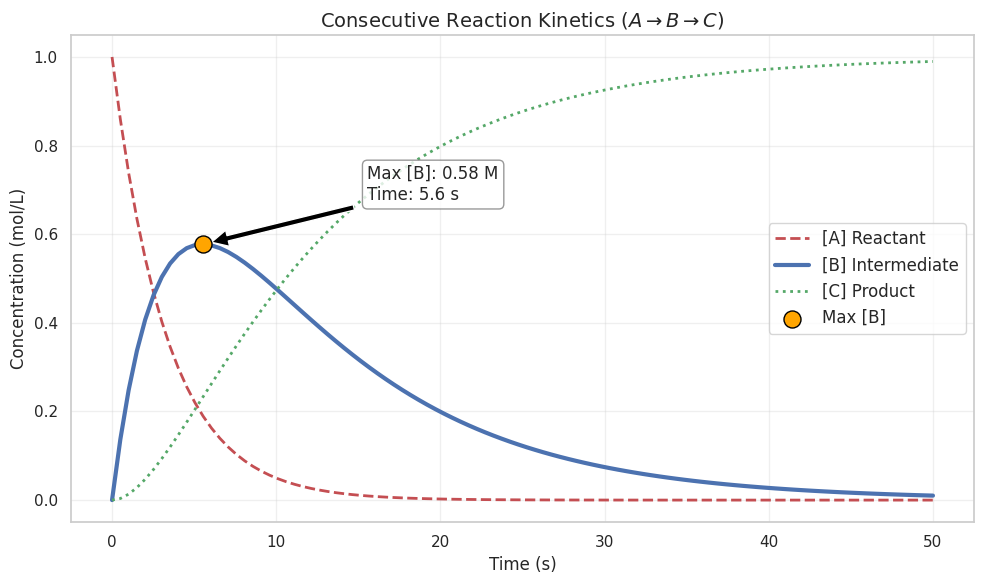

✓ 濃度–時間曲線已儲存至 Unit04_Results/01_reaction_kinetics.png


In [16]:
plt.figure(figsize=(10, 6))

# 繪製三條濃度曲線
plt.plot(t, Ca, "r--", label="[A] Reactant", linewidth=2)
plt.plot(t, Cb, "b-", label="[B] Intermediate", linewidth=3)
plt.plot(t, Cc, "g:", label="[C] Product", linewidth=2)

# 標記 B 的峰值
plt.scatter(
    [max_Cb_time],
    [max_Cb_val],
    color="orange",
    s=150,
    zorder=5,
    edgecolors="black",
    label="Max [B]"
)

# 加入註解文字
plt.annotate(
    f"Max [B]: {max_Cb_val:.2f} M\nTime: {max_Cb_time:.1f} s",
    xy=(max_Cb_time, max_Cb_val),
    xytext=(max_Cb_time + 10, max_Cb_val + 0.1),
    arrowprops=dict(facecolor="black", shrink=0.05),
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
)

plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Concentration (mol/L)", fontsize=12)
plt.title("Consecutive Reaction Kinetics ($A \\to B \\to C$)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
# 儲存圖片
plt.savefig('./Unit04_Results/01_reaction_kinetics.png')
plt.show()

print("✓ 濃度–時間曲線已儲存至 Unit04_Results/01_reaction_kinetics.png")

---
## 6. 進階模擬：溫度效應 (Temperature Effect)

我們引入 **Arrhenius Equation** 來模擬不同溫度下的反應行為。
假設：
*   反應 1 ($A \to B$): $E_{a1} = 45 \, kJ/mol$
*   反應 2 ($B \to C$): $E_{a2} = 25 \, kJ/mol$
*   因為 $E_{a1} > E_{a2}$，理論上**高溫**應有利於 $B$ 的生成。

我們比較 $T=300K$ 與 $T=320K$ 的差異。

T=360K -> k1=0.00025, k2=0.00010
T=400K -> k1=0.00357, k2=0.00073


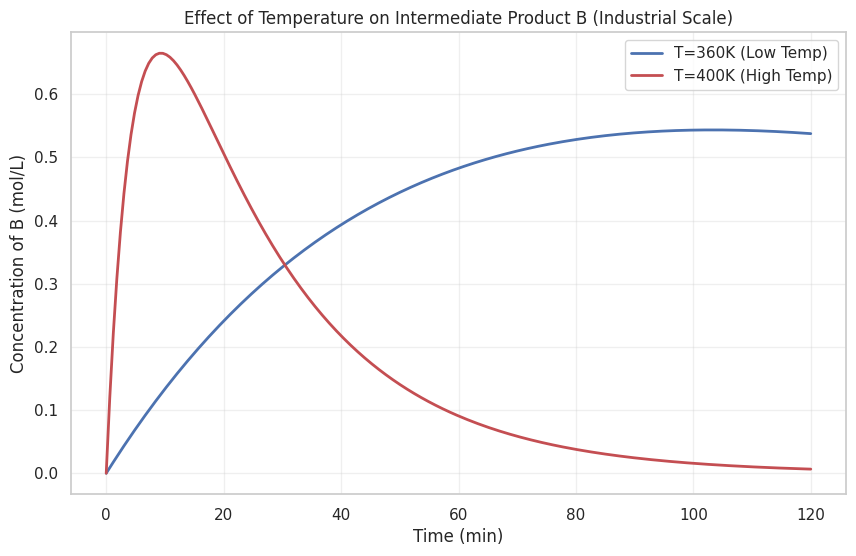

In [17]:
def arrhenius(A, Ea, T):
    R = 8.314 # J/(mol K)
    return A * np.exp(-Ea * 1000 / (R * T))

# 設定 Arrhenius 參數 (模擬真實化工製程)
# A: 頻率因子 (1/s), Ea: 活化能 (kJ/mol)
# 調整為較高活化能與適當的 A，使反應在 350K-400K 下需數分鐘至數小時
A1 = 1.0e8; Ea1 = 80 # kJ/mol
A2 = 5.0e4; Ea2 = 60 # kJ/mol

# 模擬兩種溫度 (工業常見操作溫度)
T_low = 360  # K (約 87°C)
T_high = 400 # K (約 127°C)

# 計算對應的 k 值
k1_low = arrhenius(A1, Ea1, T_low)
k2_low = arrhenius(A2, Ea2, T_low)

k1_high = arrhenius(A1, Ea1, T_high)
k2_high = arrhenius(A2, Ea2, T_high)

print(f"T={T_low}K -> k1={k1_low:.5f}, k2={k2_low:.5f}")
print(f"T={T_high}K -> k1={k1_high:.5f}, k2={k2_high:.5f}")

# 調整模擬時間範圍 (0 ~ 2小時 = 7200秒)
t_long = np.linspace(0, 7200, 200) 

# 執行模擬
sol_low = odeint(reaction_model, C0, t_long, args=(k1_low, k2_low))
sol_high = odeint(reaction_model, C0, t_long, args=(k1_high, k2_high))

# 繪圖比較 B 的濃度
plt.figure(figsize=(10, 6))
# 將 x 軸單位轉為分鐘 (min) 以利閱讀
plt.plot(t_long/60, sol_low[:, 1], 'b-', label=f'T={T_low}K (Low Temp)', linewidth=2)
plt.plot(t_long/60, sol_high[:, 1], 'r-', label=f'T={T_high}K (High Temp)', linewidth=2)

plt.xlabel("Time (min)")
plt.ylabel("Concentration of B (mol/L)")
plt.title("Effect of Temperature on Intermediate Product B (Industrial Scale)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('./Unit04_Results/02_temperature_effect.png')
plt.show()

**圖形結果分析 (Industrial Scale)：**

1.  **時間尺度 (Time Scale)**：
    *   **低溫 ($360K \approx 87^\circ C$)**：反應緩慢，藍線的峰值出現在約 **60 分鐘** 處。這代表若在較低溫操作，批次反應時間需長達一小時。
    *   **高溫 ($400K \approx 127^\circ C$)**：反應顯著加速，紅線的峰值提早至約 **10 分鐘** 處。
2.  **產能提升 (Throughput)**：
    *   將反應時間從 60 分鐘縮短至 10 分鐘，意味著在相同的反應器體積下，工廠的日產能可以提升 **6 倍**。
3.  **選擇率與產率**：
    *   紅線的峰值高度 ($C_B \approx 0.7 M$) 高於藍線 ($C_B \approx 0.6 M$)。
    *   這是因為我們設定 $E_{a1} (80) > E_{a2} (60)$，高溫更有利於主反應 $A \to B$ 的進行，抑制了副反應 $B \to C$ 的相對速率。

---
## 7. 工程指標分析：轉化率 vs 選擇率 (Conversion vs Selectivity)

化工工程師常面臨一個兩難：
*   反應太久 -> A 轉化率高，但 B 分解多，選擇率低。
*   反應太短 -> 選擇率高，但 A 沒用完，浪費原料。

我們繪製 **Yield vs Conversion** 圖來輔助決策。

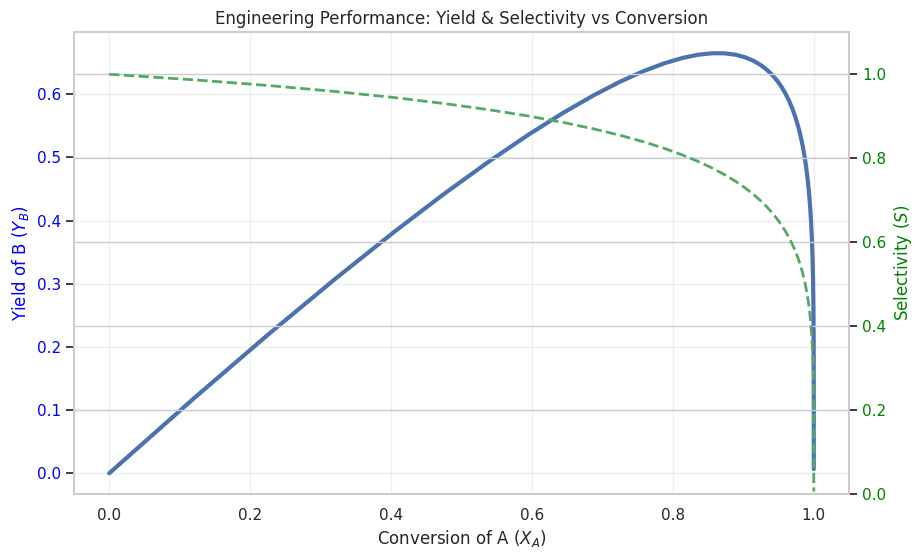

In [18]:
# 使用 T_high 的模擬結果進行分析
Ca_data = sol_high[:, 0]
Cb_data = sol_high[:, 1]

# 計算指標
# 1. 轉化率 X_A = (Ca0 - Ca) / Ca0
Conversion_A = (C0[0] - Ca_data) / C0[0]

# 2. 產率 Y_B = Cb / Ca0
Yield_B = Cb_data / C0[0]

# 3. 選擇率 S = Cb / (Ca0 - Ca)
# 注意：分母可能為 0 (t=0 時)，需處理除零錯誤
with np.errstate(divide='ignore', invalid='ignore'):
    Selectivity_B = np.where(Conversion_A > 0, Yield_B / Conversion_A, 1.0)

# 繪圖
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Conversion of A ($X_A$)')
ax1.set_ylabel('Yield of B ($Y_B$)', color='blue')
ax1.plot(Conversion_A, Yield_B, 'b-', linewidth=3, label='Yield')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()  # 建立共用 x 軸的第二個 y 軸
ax2.set_ylabel('Selectivity ($S$)', color='green')
ax2.plot(Conversion_A, Selectivity_B, 'g--', linewidth=2, label='Selectivity')
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_ylim(0, 1.1)

plt.title("Engineering Performance: Yield & Selectivity vs Conversion")
plt.savefig('./Unit04_Results/03_yield_selectivity.png')
plt.show()

**圖形結果分析：**
1.  **選擇率 (綠色虛線)**：隨著轉化率 $X_A$ 上升，選擇率 $S$ 持續下降。這是連串反應的特性，反應越久，副產物 $C$ 越多。
2.  **產率 (藍色實線)**：呈現拋物線，存在一個最大值。
3.  **操作決策 (Trade-off)**：
    *   若目標是**最大化產量**：應操作在藍線最高點對應的轉化率。
    *   若目標是**高純度/減少廢棄物**：可能會選擇在較低的轉化率停止（例如 $X_A=0.6$），此時選擇率較高，未反應的 A 可回收再利用。

---
## 8. 機器學習實戰：建立反應器代理模型 (Surrogate Modeling)

在進階應用中，我們常遇到計算量極大的物理模型（如 CFD）。
為了實現即時控制，我們可以訓練一個 ML 模型來「模仿」物理行為。

**任務目標**：
1.  **數據生成**：利用上面的 ODE 函數，隨機生成 1000 組 $(T, t)$ 操作條件，並計算對應的產率 $Y_B$。
2.  **模型訓練**：使用 `RandomForestRegressor` 學習輸入與輸出的關係。
3.  **預測優化**：使用 ML 模型繪製操作視窗，尋找最佳 $(T, t)$ 組合。

這也適用於 **PFR 反應器** 設計（將時間 $t$ 視為停留時間 $\tau$）。

已生成 1000 筆模擬數據。
特徵範例 (T, t): 
[[ 376.21780832  715.37056809]
 [ 416.55000145 1978.32935372]
 [ 401.23957593 3150.228259  ]]
標籤範例 (Yield): [0.39092775 0.06184803 0.10988007]

代理模型 R2 Score: 0.9907 (越高越好，接近 1 代表完美模仿物理模型)


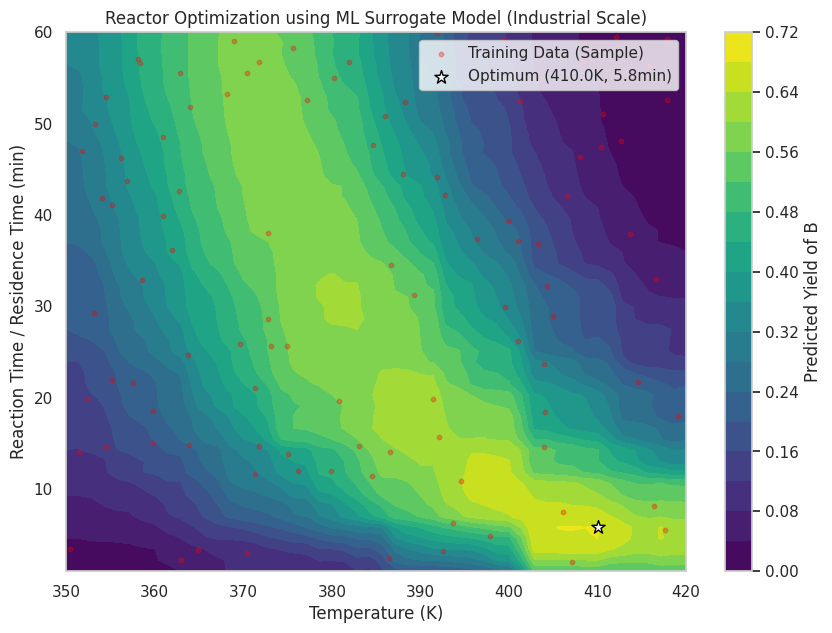

ML 模型預測的最佳操作條件：
溫度 T = 410.00 K
時間 t = 348.98 s (5.82 min)
預期產率 Yield = 0.6832


In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# 1. 數據生成 (Data Generation)
# 模擬 "做實驗" 或 "跑高階模擬" 的過程
n_samples = 1000
np.random.seed(42)

# 隨機採樣操作條件 (符合真實工廠操作範圍)
# 溫度範圍: 350K ~ 420K (約 77°C ~ 147°C)
# 時間範圍: 1 min ~ 60 min (60s ~ 3600s)
T_samples = np.random.uniform(350, 420, n_samples)
time_samples = np.random.uniform(60, 3600, n_samples)

# 收集輸出數據 (Yield of B)
Yield_samples = []

for i in range(n_samples):
    T_curr = T_samples[i]
    t_curr = time_samples[i]
    
    # 計算該溫度下的 k 值
    k1_curr = arrhenius(A1, Ea1, T_curr)
    k2_curr = arrhenius(A2, Ea2, T_curr)
    
    # 執行 ODE 模拟
    t_span = np.linspace(0, t_curr, 10) 
    sol = odeint(reaction_model, C0, t_span, args=(k1_curr, k2_curr))
    
    # 計算產率 Yield = Cb / Ca0
    Cb_final = sol[-1, 1]
    Yield_samples.append(Cb_final / C0[0])

Yield_samples = np.array(Yield_samples)

# 準備 ML 訓練資料
X_ml = np.column_stack((T_samples, time_samples)) # 特徵: [T, t]
y_ml = Yield_samples                              # 標籤: Yield

print(f"已生成 {n_samples} 筆模擬數據。")
print(f"特徵範例 (T, t): \n{X_ml[:3]}")
print(f"標籤範例 (Yield): {y_ml[:3]}")

# 2. 模型訓練 (Model Training)
X_train, X_test, y_train, y_test = train_test_split(X_ml, y_ml, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 評估模型
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"\n代理模型 R2 Score: {r2:.4f} (越高越好，接近 1 代表完美模仿物理模型)")

# 3. 應用：繪製操作地圖 (Operating Map)
# 建立網格
T_grid = np.linspace(350, 420, 50)
t_grid = np.linspace(60, 3600, 50)
TT, tt = np.meshgrid(T_grid, t_grid)

# 將網格展平以進行預測
X_grid = np.column_stack((TT.ravel(), tt.ravel()))
Y_pred_grid = rf_model.predict(X_grid)
Y_pred_grid = Y_pred_grid.reshape(TT.shape)

# 繪圖
plt.figure(figsize=(10, 7))
# 為了方便閱讀，將 y 軸時間單位轉為分鐘
contour = plt.contourf(TT, tt/60, Y_pred_grid, levels=20, cmap='viridis')
plt.colorbar(contour, label='Predicted Yield of B')
plt.scatter(T_samples[:100], time_samples[:100]/60, c='red', s=10, alpha=0.3, label='Training Data (Sample)')

# 標示最佳點
max_idx = np.argmax(Y_pred_grid)
best_T = TT.ravel()[max_idx]
best_t = tt.ravel()[max_idx]
best_Y = Y_pred_grid.ravel()[max_idx]

plt.scatter([best_T], [best_t/60], c='white', s=100, marker='*', edgecolors='black', label=f'Optimum ({best_T:.1f}K, {best_t/60:.1f}min)')

plt.xlabel('Temperature (K)')
plt.ylabel('Reaction Time / Residence Time (min)')
plt.title('Reactor Optimization using ML Surrogate Model (Industrial Scale)')
plt.legend(loc='upper right')
plt.savefig('./Unit04_Results/04_ml_optimization.png')
plt.show()

print(f"ML 模型預測的最佳操作條件：")
print(f"溫度 T = {best_T:.2f} K")
print(f"時間 t = {best_t:.2f} s ({best_t/60:.2f} min)")
print(f"預期產率 Yield = {best_Y:.4f}")

**圖形結果分析與工程意義：**

這張 **操作地圖 (Operating Map)** 揭示了化工反應器設計的關鍵權衡 (Trade-off)。

1.  **山脊效應 (The Ridge)**：
    *   圖中黃色亮區（高產率區）呈現一條從「左上」延伸至「右下」的山脊。
    *   **左上 (低溫、長時間)**：例如 $360K$ 需反應約 $50$ 分鐘。這對應到 **巨大的反應器體積** (高 CapEx)。
    *   **右下 (高溫、短時間)**：例如 $420K$ 僅需反應約 $5$ 分鐘。這對應到 **精巧的小型反應器** (低 CapEx)。

2.  **最佳操作點 (The Optimum)**：
    *   AI 建議的最佳點（白色星號）落在 **高溫區 ($T \approx 420K$)**。
    *   在此溫度下，最佳停留時間僅需約 **5 分鐘**。
    *   **PFR 設計意涵**：若我們設計一個管式反應器 (PFR)，採用高溫操作可以讓我們使用很短的管長就達到最大產量，這能大幅降低設備造價與佔地面積。

3.  **模型準確度**：
    *   $R^2$ 分數接近 1.0，證明 Random Forest 成功學會了 Arrhenius 方程式與微分方程組成的複雜非線性關係。

### 總結 (Summary)

在本單元中，我們完成了：
1.  **ODE 建模**：將化學反應速率方程轉換為 Python 函數。
2.  **數值模擬**：使用 `odeint` 成功模擬了濃度隨時間的變化。
3.  **製程優化**：確定了若要最大化產物 B，反應應在約 **{max_Cb_time:.1f} 秒** 時停止。

**思考題**：
如果 $k_2$ 變大 (B 分解得更快)，最佳反應時間會變短還是變長？最大濃度會如何變化？
試著修改上面的 `k2` 數值重新執行看看！